In [179]:
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
from tensorflow.contrib.rnn import BasicRNNCell
tf.reset_default_graph()

input_size = 60
num_units = 32
batch_size = 5

state_initial = tf.zeros([batch_size, num_units])
inputs = tf.ones([batch_size,input_size])

cell = BasicRNNCell(num_units=num_units, activation=math_ops.tanh, reuse=None)

out, state = cell(inputs, state_initial)

func = tf.reduce_mean(out)
gradients = tf.train.GradientDescentOptimizer(learning_rate=.01).compute_gradients(func)
#print('cell output size: ', cell.output_size)
#print('cell state size: ', cell.state_size)
#print(state.get_shape())




with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    func_run = sess.run(func)
    gradients_run = sess.run(gradients)
    
print(func_run)
print(gradients_run[0][0].shape)
print(gradients_run[0][1].shape)

print(gradients_run[1][0].shape)
print(gradients_run[1][1].shape)

-0.0699093
(92, 32)
(92, 32)
(32,)
(32,)


In [169]:
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
tf.reset_default_graph()


# Dimensions
batch_size = 10
Midi_high = 102
Midi_low = 24

num_timesteps = 128
input_size = 1 + 12 + 25 + 12 + 4 + 1

num_notes = Midi_high - Midi_low + 1

#Note State Batch (NSB) Generator
Note_State_Batch = tf.placeholder(tf.float32, shape=[batch_size, num_notes, num_timesteps])

# Input Kernel Pre-processing segments

# MIDI note number
Midi_indices = tf.range(start=Midi_low, limit = Midi_high+1, delta=1)
x_Midi = tf.reshape(tf.tile(Midi_indices, multiples=[batch_size*num_timesteps]), shape=[batch_size, num_notes, num_timesteps,1])
print('x_Midi shape = ', x_Midi.get_shape())

# part_pitchclass
Midi_pitchclasses = tf.squeeze(x_Midi % 12)
x_pitch_class = tf.one_hot(Midi_pitchclasses, depth=12)
print('x_pitch_class shape = ', x_pitch_class.get_shape())
print('')

# part_prev_vicinity (need to change to 1 time step in past)
NSB_flatten = tf.reshape(Note_State_Batch, [batch_size*num_timesteps, num_notes, 1])
filt_vicinity = tf.reshape(tf.reverse(tf.eye(25), axis=[0]), [25,1,25])
prev_vicinity = tf.nn.conv1d(NSB_flatten, filt_vicinity, stride=1, padding='SAME')
x_vicinity = tf.reshape(prev_vicinity, shape=[batch_size, num_notes, num_timesteps, 25])
print('NSB flat shape', NSB_flatten.get_shape())
print('x_vicinity shape = ', x_vicinity.get_shape())
print('')

#part_prev_context (need to change it to 1 time step in past)
NSB_flat_bool = tf.minimum(NSB_flatten,1) # 1 if note is played, 0 if not played
filt_context = tf.expand_dims(tf.tile(tf.reverse(tf.eye(12), axis=[0]), multiples=[(num_notes // 12)*2,1]), axis=1)
print('NSB flat bool = ', NSB_flat_bool.get_shape())
print('filt context shape = ', filt_context.get_shape())
context = tf.nn.conv1d(NSB_flat_bool, filt_context, stride=1, padding='SAME')
x_context = tf.reshape(context, shape=[batch_size, num_notes, num_timesteps, 12])
print('x context shape = ',x_context.get_shape())
print('')

#beat
Time_indices = tf.range(num_timesteps)
x_Time = tf.reshape(tf.tile(Time_indices, multiples=[batch_size*num_notes]), shape=[batch_size, num_notes, num_timesteps,1])
x_beat = tf.cast(tf.concat([x_Time%2, x_Time//2%2, x_Time//4%2, x_Time//8%2], axis=-1), dtype=tf.float32)
print('x beat shape = ', x_beat.get_shape())
print('')

#zero
x_zero = tf.zeros([batch_size, num_notes, num_timesteps,1])


#Final Vector
Note_State_Expand = tf.concat([tf.cast(x_Midi,dtype=tf.float32), x_pitch_class, x_vicinity, x_context, x_beat, x_zero], axis=-1)

print('Note_State_Filt Shape = ', x.get_shape())


x_Midi shape =  (10, 79, 128, 1)
x_pitch_class shape =  (10, 79, 128, 12)

NSB flat shape (1280, 79, 1)
x_vicinity shape =  (10, 79, 128, 25)

NSB flat bool =  (1280, 79, 1)
filt context shape =  (144, 1, 12)
x context shape =  (10, 79, 128, 12)

x beat shape =  (10, 79, 128, 4)

Note_State_Filt Shape =  (10, 79, 128, 55)


In [170]:
# LSTM time-wise 
# This section is the 'Model LSTM-TimeAxis' block and will run a number of LSTM cells over the time axis.
# Every note and sample in the batch will be run in parallel with the same LSTM weights
# The input data is 'Note_State_Filt' with dimensions batch_size x num_notes x num_timesteps x input_size
# The output will be 'Hid_State_Final' with dimensions batch_size x num_notes x num_timesteps x num_units


num_units = 50


# Reshape the input
# batch_size and num_notes dimensions of input are flattened to treat as single 'batch' dimension for LSTM cell
# will be reshaped at the end of this block for the next stage
Note_State_Expand_Flatten = tf.reshape(Note_State_Expand, shape=[batch_size*num_notes, num_timesteps, input_size])


#Instantiate Time-Wise Cell
lstmcell_time = BasicLSTMCell(num_units=num_units, forget_bias=1.0, state_is_tuple=True,activation=math_ops.tanh, reuse=None)


#Run through LSTM time steps and generate time-wise sequence of outputs
out_flat, _ = tf.nn.dynamic_rnn(lstmcell_time, Note_State_Expand_Flatten, dtype=tf.float32)


#Unflatten the 1st 2 dimensions [Lbatch, Nnotes, num_timesteps, num_units]
timewise_out = tf.reshape(out_flat, shape=[batch_size, num_notes, num_timesteps, num_units])

print('Time wise output shape: ', timewise_out.shape)





Tensor("rnn/while/Identity_2:0", shape=(790, 50), dtype=float32)
Time wise output shape:  (10, 79, 128, 50)


In [171]:
# LSTM note-wise
# This section is the 'Model LSTM-Note Axis' block and runs a number of LSTM cells from low note to high note
# A batches and time steps are run in parallel in
# The input sequence to the LSTM cell is the hidden state output from the previous block for each note
#  concatenated with a sampled output from the previous note step
# The input data is 'Hid_State_Final' with dimensions batch_size x num_notes x num_timesteps x num_units
# The output will be:
#    - LogP with dimensions batch_size x num_notes x num_timesteps x 3
#    - note_gen with dimensions batch_size x num_notes x num_timesteps x 1

# number of outputs is number of note+articulation combinations
#    - 0: note is not played
#    - 1: note is played and held
#    - 2: note is played and articulated

num_class = 3

# Reshape the input
# batch_size and num_timesteps dimensions of input are flattened to treat as single 'batch' dimension for LSTM cell
notewise_in = tf.reshape(timewise_out, [batch_size*num_timesteps, num_notes, num_units])
print('Note-wise input reshape: ', notewise_in.shape)



# For this LSTM cell, can't use tf.nn.dynamic_rnn because samples have to be generated and fed back to for subsequent notes
# need to feed the generated output for note 'n-1' into the generation of note 'n'
# Will use 'for' loop and call the LSTM cell each time


#Instantiate Note-Wise Cell
lstmcell_note = BasicLSTMCell(num_units=num_class, forget_bias=1.0, state_is_tuple=True,activation=math_ops.tanh, reuse=None)


#Set values for initial LSTM state and sampled note
logP_state_initial = tf.zeros([batch_size*num_timesteps, num_class])
pa_gen_initial = tf.zeros([batch_size*num_timesteps,1])

logP_n_state = LSTMStateTuple(logP_state_initial, logP_state_initial) #(c, h)
pa_gen_n = pa_gen_initial

logP_out_list=[]
va_gen_out_list=[]

#Run through notes for note-wise LSTM to obtain P(va(n) | va(<n))
for n in range(timewise_out.shape[1]):
    cell_inputs = tf.concat([notewise_in[:,n,:], tf.cast(pa_gen_n, dtype=tf.float32)], axis=1)
    logP_n_out, logP_n_state = lstmcell_note(cell_inputs, logP_n_state)
    pa_gen_n = tf.multinomial(logits=logP_n_out, num_samples=1)   
    logP_out_list.append(logP_n_out)
    va_gen_out_list.append(pa_gen_n)
    
# Convert output list to a Tensor
logP_out = tf.reshape(tf.stack(logP_out_list, axis=1), [batch_size, num_notes, num_timesteps, num_class])
va_gen_out = tf.reshape(tf.stack(va_gen_out_list, axis=1),  [batch_size, num_notes, num_timesteps, 1])
    #p_note_out = tf.nn.softmax(logits=y_note_out)


print(logP_out.get_shape())
print(va_gen_out.get_shape())



Note-wise input reshape:  (1280, 79, 50)
Tensor("zeros_1:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_1:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_3:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_5:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_7:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_9:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_11:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_13:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_15:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_17:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_19:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_21:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_23:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_25:0", shape=(1280, 3), dtype=float32)
Tensor("basic_lstm_cell/add_27:0", shape=

In [172]:
# Loss Function

# This section is the Loss Function Block
# y_out generates the 3x play-articulate log probabilities for each note, at every time step, for every batch
# Input Note_State_Batch contains the actual class played for each note, at every time step, for every batch
# The Loss Function should match up the y_out log probabilities at time 't-1' to the ground truth class at time 't'
# Remove the following:
#    - 1st element of Note_State Batch in 't' dimension.  This is irrelevant as a label, anyways.
#    - last element of logP_out in 't' dimension.  There is no corresponding future Note_State_Batch element , anyways
# y_out elements will now correspond to the Note_State_Batch elements that it is trying to predict.


print(logP_out.get_shape())
print(Note_State_Batch.get_shape())

logP_out_align = tf.slice(logP_out, [0,0,0,0],[batch_size, num_notes, num_timesteps-1, num_class])
Note_State_Batch_align = tf.slice(Note_State_Batch, [0,0,1],[batch_size, num_notes, num_timesteps-1])

print(logP_out_align.get_shape())
print(Note_State_Batch_align.get_shape())

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logP_out_align, labels=tf.cast(Note_State_Batch_align,dtype=tf.int64))
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate = .1).minimize(loss)
print(loss)


(10, 79, 128, 3)
(10, 79, 128)
(10, 79, 127, 3)
(10, 79, 127)
Tensor("Mean:0", shape=(), dtype=float32)


In [173]:
# Training
N_epochs = 100
loss_hist=[]
X_train = np.random.randint(low=0, high=3, size=[batch_size, num_notes, num_timesteps]).astype(np.float32)
print(X_train.shape)
print(Note_State_Batch.get_shape())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(N_epochs):
        loss_out, _ = sess.run([loss, optimizer], feed_dict={Note_State_Batch: X_train})
        print('epoch = ', epoch, '; loss = ', loss_out)
        loss_hist.append(loss_out)

(10, 79, 128)
(10, 79, 128)
epoch =  0 ; loss =  1.12509
epoch =  1 ; loss =  1.10727
epoch =  2 ; loss =  1.1029
epoch =  3 ; loss =  1.10188
epoch =  4 ; loss =  1.1014
epoch =  5 ; loss =  1.10102
epoch =  6 ; loss =  1.10063
epoch =  7 ; loss =  1.10007
epoch =  8 ; loss =  1.09961
epoch =  9 ; loss =  1.09922
epoch =  10 ; loss =  1.09913
epoch =  11 ; loss =  1.10096
epoch =  12 ; loss =  1.10364
epoch =  13 ; loss =  1.10026
epoch =  14 ; loss =  1.09901
epoch =  15 ; loss =  1.09878
epoch =  16 ; loss =  1.09874
epoch =  17 ; loss =  1.09878
epoch =  18 ; loss =  1.09863
epoch =  19 ; loss =  1.09846
epoch =  20 ; loss =  1.09842
epoch =  21 ; loss =  1.09828
epoch =  22 ; loss =  1.09817
epoch =  23 ; loss =  1.09804
epoch =  24 ; loss =  1.09809
epoch =  25 ; loss =  1.0979
epoch =  26 ; loss =  1.09778
epoch =  27 ; loss =  1.09763
epoch =  28 ; loss =  1.09763
epoch =  29 ; loss =  1.09757
epoch =  30 ; loss =  1.09742
epoch =  31 ; loss =  1.09734
epoch =  32 ; loss =  1.0

100

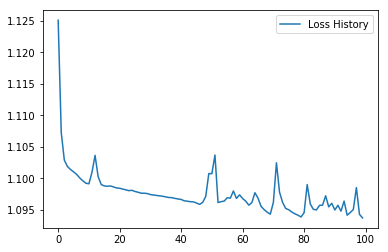

In [180]:
plt.plot(loss_hist, label="Loss History")
plt.legend()
plt.show
len(loss_hist)

In [182]:
# Music Generation

# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)

# input = initial note vector
# for t = 1:Tsong
#    input --> input kernel
#    run through 1 'call' of Model LSTM with present parameters / states
#    run through note-wise LSTM block as normally done to produce vector of generated samples
#    input = generated samples
#    music_sequence.append(input)

# store batch of music sequences in .MIDI files

Items to Experiment with:
- different T length or variable length T from batch-to-batch for training
- categorize music, either through (unsupervised) clustering or (supervised) labeled music folders.  For clustering, the model would possibly find 'k' 'centroids' in an unsupervised manner each with its own music distribution, so during the music generation stage, 1 of these centroids would be selected for a piece of music.  
- more advanced sampling/exploring for training/music generation

In [125]:
logits = np.array([3, 3, 5], dtype=np.float32)
#label_rest = np.array([1, 0, 0])
#label_play_hold = np.array([0, .85, .15])
#label_play_artic= np.array([0, .15, .85])

#labels = label_play_hold

softmax = tf.n.softmax(logits=logits)
#loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
num_classes = 3

with tf.Session() as sess:
    p=sess.run(softmax)
    loss_run = sess.run(loss
                       )
note_gen = np.random.choice(range(num_classes), p=p)

print(loss_run)


#Will need some sort of 'for' loop for musical generation
#state_initial = tf.zeros([batch_size*num_notes, num_units])
#state = LSTMStateTuple(state_initial, state_initial) #(c, h)
#for t in range(num_timesteps):
#    cell_inputs = Note_State_Flatten[:,:,t]
#    out, state = lstmcell(cell_inputs, state)
#func = tf.reduce_mean(out_unflatten)
#gradients =  tf.train.GradientDescentOptimizer(learning_rate=.01).compute_gradients(func)

1.93954
